# Autoencoding our variables

### Import the python torch and tensorflow modules and make sure we're ready to rock and roll

In [1]:
import sys
!which {sys.executable}

~/miniconda3/envs/gpu_notebook/bin/python3.11


In [2]:
import os
import sys
import torch

import tensorflow as tf
from tensorflow.keras import layers, models

if not torch.cuda.is_available():
    print("FATAL: Please run this notebook in an environment with CUDA available", file=sys.stderr)
else:
    print("Lets go GPU", file=sys.stderr)

2025-01-30 12:08:07.917746: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Lets go GPU


## Import the libraries.

This is my standard import.

In [3]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import json
import random

from itertools import cycle
from collections import Counter

import networkx as nx
import community

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor, ClassifierChain
from sklearn.metrics import mean_squared_error

from scipy.stats import linregress
from scipy.cluster.hierarchy import linkage, fcluster

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
  import google.colab
  IN_COLAB = True
  !pip install adjustText
  from google.colab import drive
  drive.mount('/content/drive')
  datadir = '/content/drive/MyDrive/Projects/CF/Adelaide/CF_Data_Analysis'
except ImportError:
  IN_COLAB = False
  datadir = '..'


from socket import gethostname
hostname = gethostname()
if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False

import cf_analysis_lib


from adjustText import adjust_text

## Read the data

In [4]:
sequence_type = "MGI"
datadir = '..'
#sslevel = 'level2_norm_ss.tsv.gz'
sslevel = 'subsystems_norm_ss.tsv.gz'
ss_df = cf_analysis_lib.read_subsystems(os.path.join(datadir, sequence_type, "FunctionalAnalysis", "subsystems", sslevel), sequence_type)
ss_df = ss_df.T
print(f"The subsystems df has shape: {ss_df.shape}")

taxa = "family"
genus_otu = cf_analysis_lib.read_taxonomy(datadir, sequence_type, taxa)
genus_otu = genus_otu.T
print(f"The taxonomy df has shape: {genus_otu.shape}")
metadata = cf_analysis_lib.read_metadata(datadir, sequence_type, categorise=True)
print(f"The metadata df has shape: {metadata.shape}")
df = ss_df.merge(genus_otu, left_index=True, right_index=True, how='inner')
print(df.shape)
df.head(5)

The subsystems df has shape: (127, 769)
The taxonomy df has shape: (127, 743)
The metadata df has shape: (127, 166)
(127, 1512)


2,3-diacetamido-2,3-dideoxy-d-mannuronic acid  \
1068841_20180306_S                                      10.085904   
1447437_20171212_S                                      59.260325   
1128691_20171206_S                                       0.000000   
1128691_20171218_S                                       0.000000   
1128691_20180116_S                                      14.478968   

                    2-O-alpha-mannosyl-D-glycerate utilization  \
1068841_20180306_S                                 2784.895948   
1447437_20171212_S                                 1065.438272   
1128691_20171206_S                                  426.619709   
1128691_20171218_S                                  659.087578   
1128691_20180116_S                                  159.268644   

                    2-aminophenol Metabolism  \
1068841_20180306_S                516.160945   
1447437_20171212_S                543.947408   
1128691_20171206_S                912.767750   
1128691_20171218_S                864.137047   
1128691_20180116_S                593.637673   

                    2-ketoacid oxidoreductases disambiguation  \
1068841_20180306_S                                 231.778018   
1447437_20171212_S                                 554.136026   
1128691_20171206_S                                  49.606943   
1128691_20171218_S                                 139.140711   
1128691_20180116_S                                  48.263225   

                    2-oxoglutarate dehydrogenase   2-phosphoglycolate salvage  \
1068841_20180306_S                     122.573392                  342.327431   
1447437_20171212_S                     428.171446                  301.915763   
1128691_20171206_S                     213.640568                  277.798880   
1128691_20171218_S                     235.318676                  355.174973   
1128691_20180116_S                     358.354449                  202.705547   

                    3-amino-5-hydroxybenzoic Acid Synthesis  \
1068841_20180306_S                               783.041862   
1447437_20171212_S                               679.310468   
1128691_20171206_S                               423.312580   
1128691_20171218_S                               538.254855   
1128691_20180116_S                               348.701804   

                    4-hydroxybenzoyl-CoA reductase  \
1068841_20180306_S                             0.0   
1447437_20171212_S                             0.0   
1128691_20171206_S                             0.0   
1128691_20171218_S                             0.0   
1128691_20180116_S                             0.0   

                    5-methylaminomethyl-2-thiouridine  \
1068841_20180306_S                        4136.703664   
1447437_20171212_S                        3913.676651   
1128691_20171206_S                        2093.412992   
1128691_20171218_S                        2050.494687   
1128691_20180116_S                        1570.967988   

                    A Hypothetical Protein Related to Proline Metabolism  ...  \
1068841_20180306_S                                         827.439614     ...   
1447437_20171212_S                                         732.956657     ...   
1128691_20171206_S                                         236.459761     ...   
1128691_20171218_S                                         341.749115     ...   
1128691_20180116_S                                         205.118708     ...   

                    Pelagicoccaceae  Puniceicoccaceae  Chthoniobacteraceae  \
1068841_20180306_S         0.000000          0.808564                  0.0   
1447437_20171212_S         1.271183          0.635592                  0.0   
1128691_20171206_S         0.000000         10.749798                  0.0   
1128691_20171218_S         0.000000          0.000000                  0.0   
1128691_20180116_S         0.000000         15.607929                  0.0   

                    Terrimicrobiaceae 

## Somewhere to save the outputs!

In [5]:
outdir = 'cluster_gbrfs_dev'
os.makedirs(outdir, exist_ok=True)

### Split the data

In [6]:
training_data, validate_data = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train: {training_data.shape}")
print(f"Test: {validate_data.shape}")

Train: (101, 1512)
Test: (26, 1512)


## Develop an autoencoder

Because an autoencoder reconstructs its inputs, the “labels” (y) are the same as the features (X), so `x=training_data`, and `y=training_data`.

In [7]:

# 1) Define network parameters
input_dim = len(df.columns)
latent_dim = 50  # tweak this

# 2) Build the encoder
encoder_input = tf.keras.Input(shape=(input_dim,))
x = layers.Dense(512, activation='relu')(encoder_input)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
encoder_output = layers.Dense(latent_dim, activation='linear')(x)

# 3) Build the decoder
decoder_input = layers.Input(shape=(latent_dim,))
y = layers.Dense(128, activation='relu')(decoder_input)
y = layers.Dense(512, activation='relu')(y)
decoder_output = layers.Dense(input_dim, activation='linear')(y)

# 4) Create autoencoder
encoder = tf.keras.Model(encoder_input, encoder_output, name="encoder")
decoder = tf.keras.Model(decoder_input, decoder_output, name="decoder")

autoencoder_input = tf.keras.Input(shape=(input_dim,))
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)

autoencoder = tf.keras.Model(autoencoder_input, decoded, name="autoencoder")

# 5) Compile & train
autoencoder.compile(optimizer='adam', loss='mse')
result = autoencoder.fit(
    x=training_data,
    y=training_data,
    epochs=200,
    batch_size=16,
    validation_data=(validate_data, validate_data),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# 6) Extract low-dimensional features
train_latent = encoder.predict(training_data)
val_latent = encoder.predict(validate_data)
all_data = encoder.predict(df)

2025-01-06 11:23:13.355745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:41:00.0, compute capability: 7.0


Epoch 1/200


2025-01-06 11:23:15.733702: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555587156e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-06 11:23:15.733758: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2025-01-06 11:23:15.740036: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-06 11:23:15.758811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2025-01-06 11:23:15.889090: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 [==============================] - 3s 45ms/step - loss: 103547576.0000 - val_loss: 96982920.0000
Epoch 2/200
7/7 [==============================] - 0s 10ms/step - loss: 73682288.0000 - val_loss: 50401084.0000
Epoch 3/200
7/7 [==============================] - 0s 10ms/step - loss: 48798624.0000 - val_loss: 40797892.0000
Epoch 4/200
7/7 [==============================] - 0s 10ms/step - loss: 43977028.0000 - val_loss: 34919888.0000
Epoch 5/200
7/7 [==============================] - 0s 10ms/step - loss: 39510248.0000 - val_loss: 32158834.0000
Epoch 6/200
7/7 [==============================] - 0s 10ms/step - loss: 35342496.0000 - val_loss: 25179018.0000
Epoch 7/200
7/7 [==============================] - 0s 10ms/step - loss: 28869844.0000 - val_loss: 19165406.0000
Epoch 8/200
7/7 [==============================] - 0s 10ms/step - loss: 23247646.0000 - val_loss: 14312478.0000
Epoch 9/200
7/7 [==============================] - 0s 10ms/step - loss: 19141536.0000 - val_loss: 11022998.0000
Epo

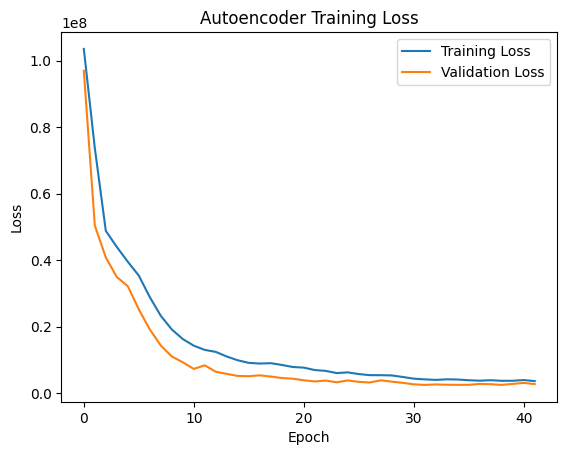

In [8]:
# Plot training & validation loss
plt.plot(result.history['loss'], label='Training Loss')
plt.plot(result.history['val_loss'], label='Validation Loss')

plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
val_latent.shape

(26, 50)

# Predict which original features cluster

We're going to use two ways to do this.

## Step 1, look directly at the weight matrix of the first encoder layer.

First encoder layer is typically a Dense layer mapping from 1,512 inputs to something like 512 or 128 hidden units.
The layer’s weight matrix 𝑊 has shape (1512,hidden_units).

A large (positive or negative) weight in row 𝑖 (feature 𝑖) and column ℎ (hidden unit ℎ) can indicate that feature 𝑖 is strongly influencing hidden unit ℎ.

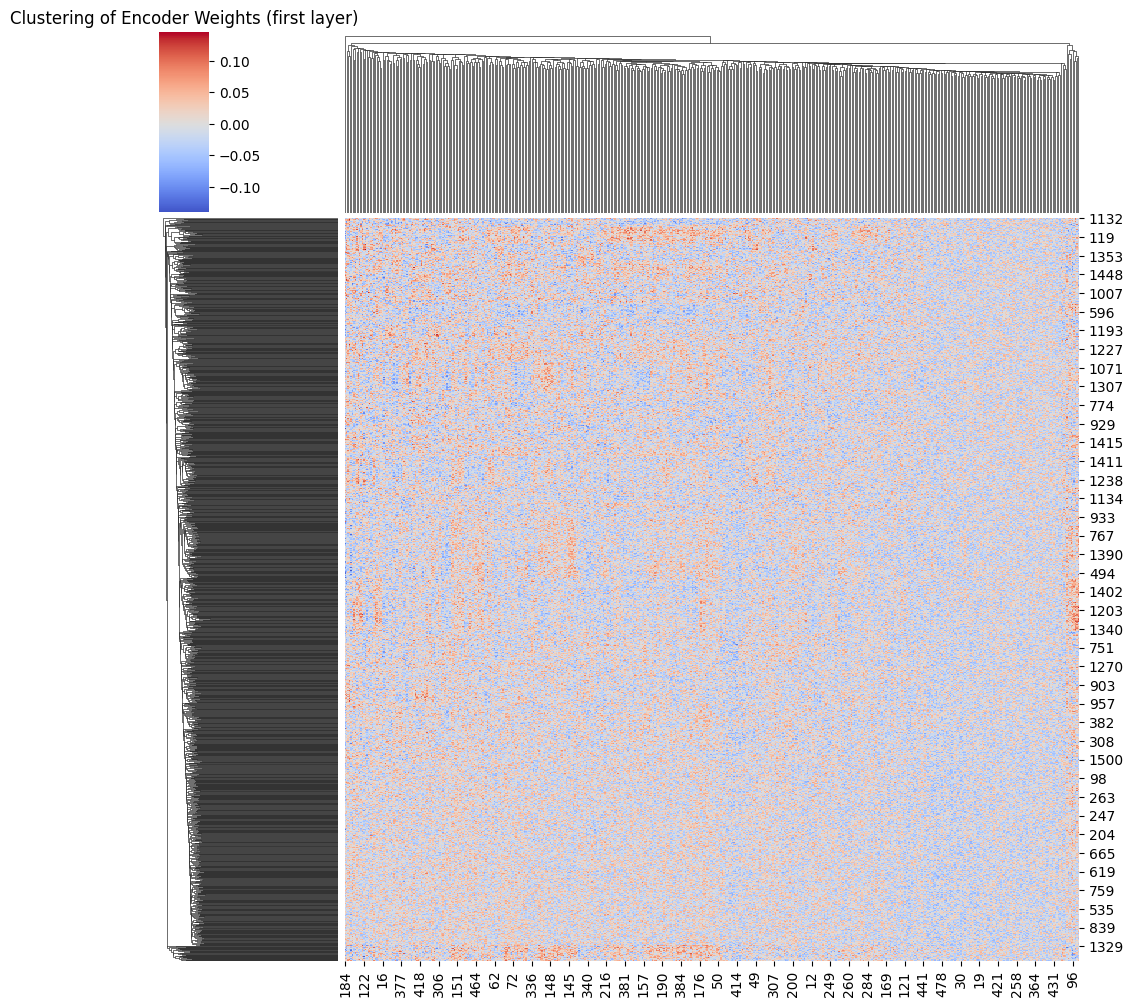

In [9]:
first_layer = encoder.layers[1]
weights, biases = first_layer.get_weights()  # 'weights' shape: (1512, hidden_units)

# Cluster the weight matrix
sns.clustermap(weights, cmap='coolwarm', center=0)
plt.title("Clustering of Encoder Weights (first layer)")
plt.show()

# Approach 2. Looking at the correlation to the encoded data

We compute Correlation Between Each Original Feature and Each Latent Dimension

In [10]:
num_features = df.shape[1]  # 1512
num_latent_dims = all_data.shape[1]       # 50 - the number of output layers

corr_matrix = pd.DataFrame(index=df.columns, columns=[f"LD_{i}" for i in range(num_latent_dims)])

for i in range(num_features):
    for j in range(num_latent_dims):
        try:
            corr = np.corrcoef(df.iloc[:, i], all_data[:, j])[0, 1]
            corr_matrix.iloc[i, j] = corr
        except:
            print(f"Error predicting {i} and {j}", file=sys.stderr)
            break

corr_matrix = corr_matrix.astype(float)
corr_matrix.head()

LD_0      LD_1      LD_2  \
2,3-diacetamido-2,3-dideoxy-d-mannuronic acid -0.122567  0.040698  0.110837   
2-O-alpha-mannosyl-D-glycerate utilization    -0.102506 -0.430371  0.481486   
2-aminophenol Metabolism                      -0.232827 -0.137040  0.528279   
2-ketoacid oxidoreductases disambiguation     -0.493437 -0.214113 -0.019611   
2-oxoglutarate dehydrogenase                   0.247454  0.195627 -0.054228   

                                                   LD_3      LD_4      LD_5  \
2,3-diacetamido-2,3-dideoxy-d-mannuronic acid  0.082793 -0.058412  0.135519   
2-O-alpha-mannosyl-D-glycerate utilization    -0.231881  0.602033  0.152453   
2-aminophenol Metabolism                       0.192392  0.142062  0.296070   
2-ketoacid oxidoreductases disambiguation      0.444348 -0.554268 -0.292603   
2-oxoglutarate dehydrogenase                   0.244851 -0.397870 -0.054091   

                                                   LD_6      LD_7      LD_8  \
2,3-diacetamido-2,3-dideoxy-d-mannuronic acid  0.010866 -0.046698  0.017811   
2-O-alpha-mannosyl-D-glycerate utilization     0.659490 -0.225405 -0.006777   
2-aminophenol Metabolism                       0.109720  0.147185  0.018317   
2-ketoacid oxidoreductases disambiguation     -0.069998  0.065117  0.454323   
2-oxoglutarate dehydrogenase                  -0.438263  0.430554 -0.262091   

                                                   LD_9  ...     LD_40  \
2,3-diacetamido-2,3-dideoxy-d-mannuronic acid  0.097585  ...  0.185968   
2-O-alpha-mannosyl-D-glycerate utilization    -0.122953  ... -0.625942   
2-aminophenol Metabolism                      -0.242676  ...  0.029546   
2-ketoacid oxidoreductases disambiguation      0.418789  ...  0.466845   
2-oxoglutarate dehydrogenase                  -0.309454  ...  0.407947   

                                                  LD_41     LD_42     LD_43  \
2,3-diacetamido-2,3-dideoxy-d-mannuronic acid -0.332083 -0.228017  0.027948   
2-O-alpha-mannosyl-D-glycerate utilization     0.128261  0.109556 -0.402889   
2-aminophenol Metabolism                      -0.378955 -0.337171  0.084859   
2-ketoacid oxidoreductases disambiguation     -0.267414 -0.252069  0.026985   
2-oxoglutarate dehydrogenase                  -0.214571 -0.234385  0.519138   

                                                  LD_44     LD_45     LD_46  \
2,3-diacetamido-2,3-dideoxy-d-mannuronic acid  0.137112  0.077301 -0.102881   
2-O-alpha-mannosyl-D-glycerate utilization    -0.072175  0.349712  0.568544   
2-aminophenol Metabolism                       0.320935  0.035695  0.206049   
2-ketoacid oxidoreductases disambiguation      0.109074  0.261875 -0.444838   
2-oxoglutarate dehydrogenase                   0.171343 -0.364001 -0.290218   

                                                  LD_47     LD_48     LD_49  
2,3-diacetamido-2,3-dideoxy-d-mannuronic acid  0.161759  0.179087 -0.008643  
2-O-alpha-mannosyl-D-glycerate utilization    -0.506315 -0.393792 -0.601483  
2-aminophenol Metabolism                       0.025541  0.291453 -0.038500  
2-ketoacid oxidoreductases disambiguation      0.168218  0.439094  0.065867  
2-oxoglutarate dehydrogenase                   0.358103  0.351172  0.448743  

[5 rows x 50 columns]

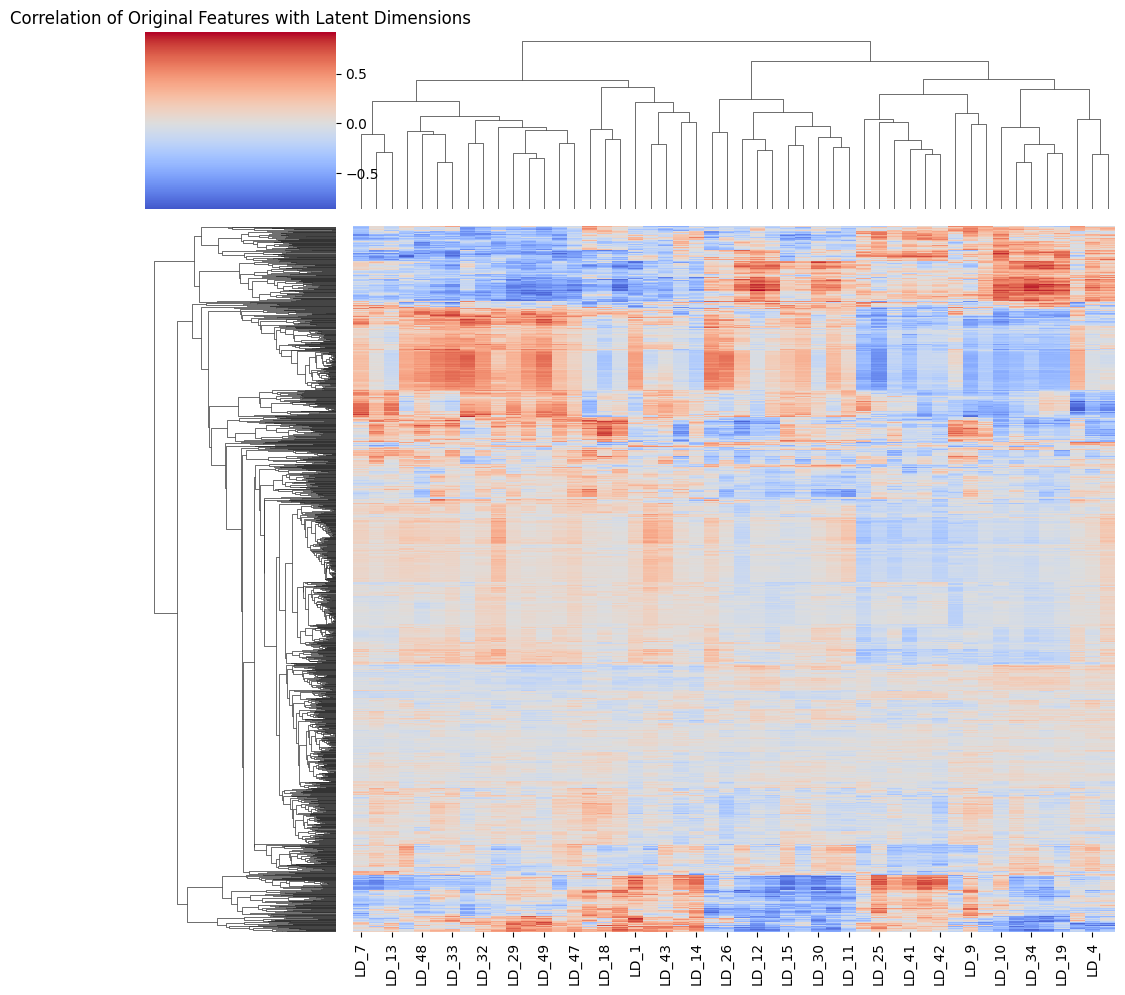

In [11]:
# plot the correlation matrix
# we save the clustermap to access the data
g = sns.clustermap(corr_matrix, cmap='coolwarm', center=0)
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_yticks([])
plt.title("Correlation of Original Features with Latent Dimensions")
plt.tight_layout()
plt.show()

Now we extract a sorted list of feature names according to the hierarchical clustering

In [12]:
clustered_feature_order = g.dendrogram_row.reordered_ind
clustered_feature_names = [df.columns[i] for i in clustered_feature_order]
clustered_feature_names[:10]

['Transcription factors, cyanobacterial RpoD-like sigma factors',
 'Glycogen metabolism',
 'Cluster containing Glutathione synthetase',
 'tRNA aminoacylation, Ala',
 'Antibiotic targets in protein synthesis',
 'Mupirocin resistance',
 'tRNA aminoacylation, Ile',
 'DAP (1,3-diaminopropane) production',
 'dTDP-rhamnose synthesis',
 'dTDP-rhamnose synthesis -- gjo']

## Alternate way to do the clustering

Here, we take the correlation matrix from the ANN - correlating which of our 1512 features map to the same output nodes from the ANN and we build clusters using k-means hierarchical clustering.

The 150 clusters is completely random - except it only gives 3 singletons, and breaks the Pseudomonas cluster down quite a bit.

In [13]:
# Calculate linkage on the rows (i.e., the features)
Z = linkage(corr_matrix, method='ward', metric='euclidean')

k = 150  # more clusters, smaller groups!
clusters = fcluster(Z, k, criterion='maxclust')  # Each feature gets a cluster ID [1..k]

# create a df with the cluster assignments
cluster_assignments = pd.DataFrame({
    "Feature": corr_matrix.index,  # the feature names
    "Cluster": clusters
})
cluster_assignments.sort_values("Cluster", inplace=True)

### Print out the clusters that contain _Pseudomonas_ subsystems

In [14]:
interesting_cluster = None
interesting_cluster_count = 0
grouped = cluster_assignments.groupby("Cluster")
for cluster_id, group in grouped:
    if group['Feature'].str.contains('Pseudomonas').any():
        if group['Feature'].str.contains('Pseudomonas').sum() > interesting_cluster_count:
            interesting_cluster_count = group['Feature'].str.contains('Pseudomonas').sum()
            interesting_cluster = cluster_id
        print(f"--- Cluster {cluster_id} : Length {group['Feature'].shape[0]} ---")
        print(group["Feature"].tolist())
        print()

--- Cluster 40 : Length 4 ---
['Maintenance of outer membrane lipid asymmetry', 'Uridine to beta-Alanine and Thymine to 3-aminoisobutanoate module', 'Tripartite multidrug efflux systems (of RND type) in Pseudomonas', 'Nucleoside ABC transporter cluster']

--- Cluster 45 : Length 43 ---
['Sulfate assimilation related cluster', 'Outer membrane porins in Pseudomonas and Acinetobacter', 'Mycobacterial gene cluster associated with resistance against FAS-II antibiotics', 'Trans-envelope signaling system VreARI in Pseudomonas', 'Marinobacteraceae', 'Type III secretion systems', 'Quorum sensing regulation in Pseudomonas', 'Geothermobacteraceae', 'Sulfur transfer pathway CsdAEL', 'Rhamnolipids in Pseudomonas', 'Biogenesis of cbb3-type cytochrome c oxidases', 'Type III secretion system', 'Extracellular matrix proteins (PEL) involved in glucose-rich biofilm formation in Pseudomonas', 'Extracellular matrix proteins (PSL) involved in mannose-rich biofilm formation in Pseudomonas', 'Type III secreti

### How many singletons are there in the groups?

In [15]:
singletons = 0
for cluster_id, group in grouped:
    if group['Feature'].shape[0] == 1:
        singletons+=1
print(f"There are {singletons} single clusters")

There are 3 single clusters


## Write all the clusters out

This is so we can use them again!

In [28]:
grouped = cluster_assignments.groupby("Cluster")
with open(os.path.join(outdir, 'cluster_features.txt'), 'w') as out:
    for cluster_id, group in grouped:
        print(f"--- Cluster {cluster_id} : Length {group['Feature'].shape[0]} ---", file=out)
        print(group["Feature"].tolist(), file=out)
        print(file=out)
cluster_assignments.to_csv(os.path.join(outdir, 'clusters.tsv'), sep="\t")

In [16]:
intcol = 'Pseudomonas Culture'
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
merged_df_clust = df_clust.join(metadata[[intcol]])
merged_df_clust.to_csv(os.path.join(outdir, 'Pseudomonas_cluster.tsv'), sep="\t")

### Cluster correlations

Now we have clusters, lets take one cluster and see how it correlates to itself.

Note that the ANN has learnt things that both positively and negatively correlate.

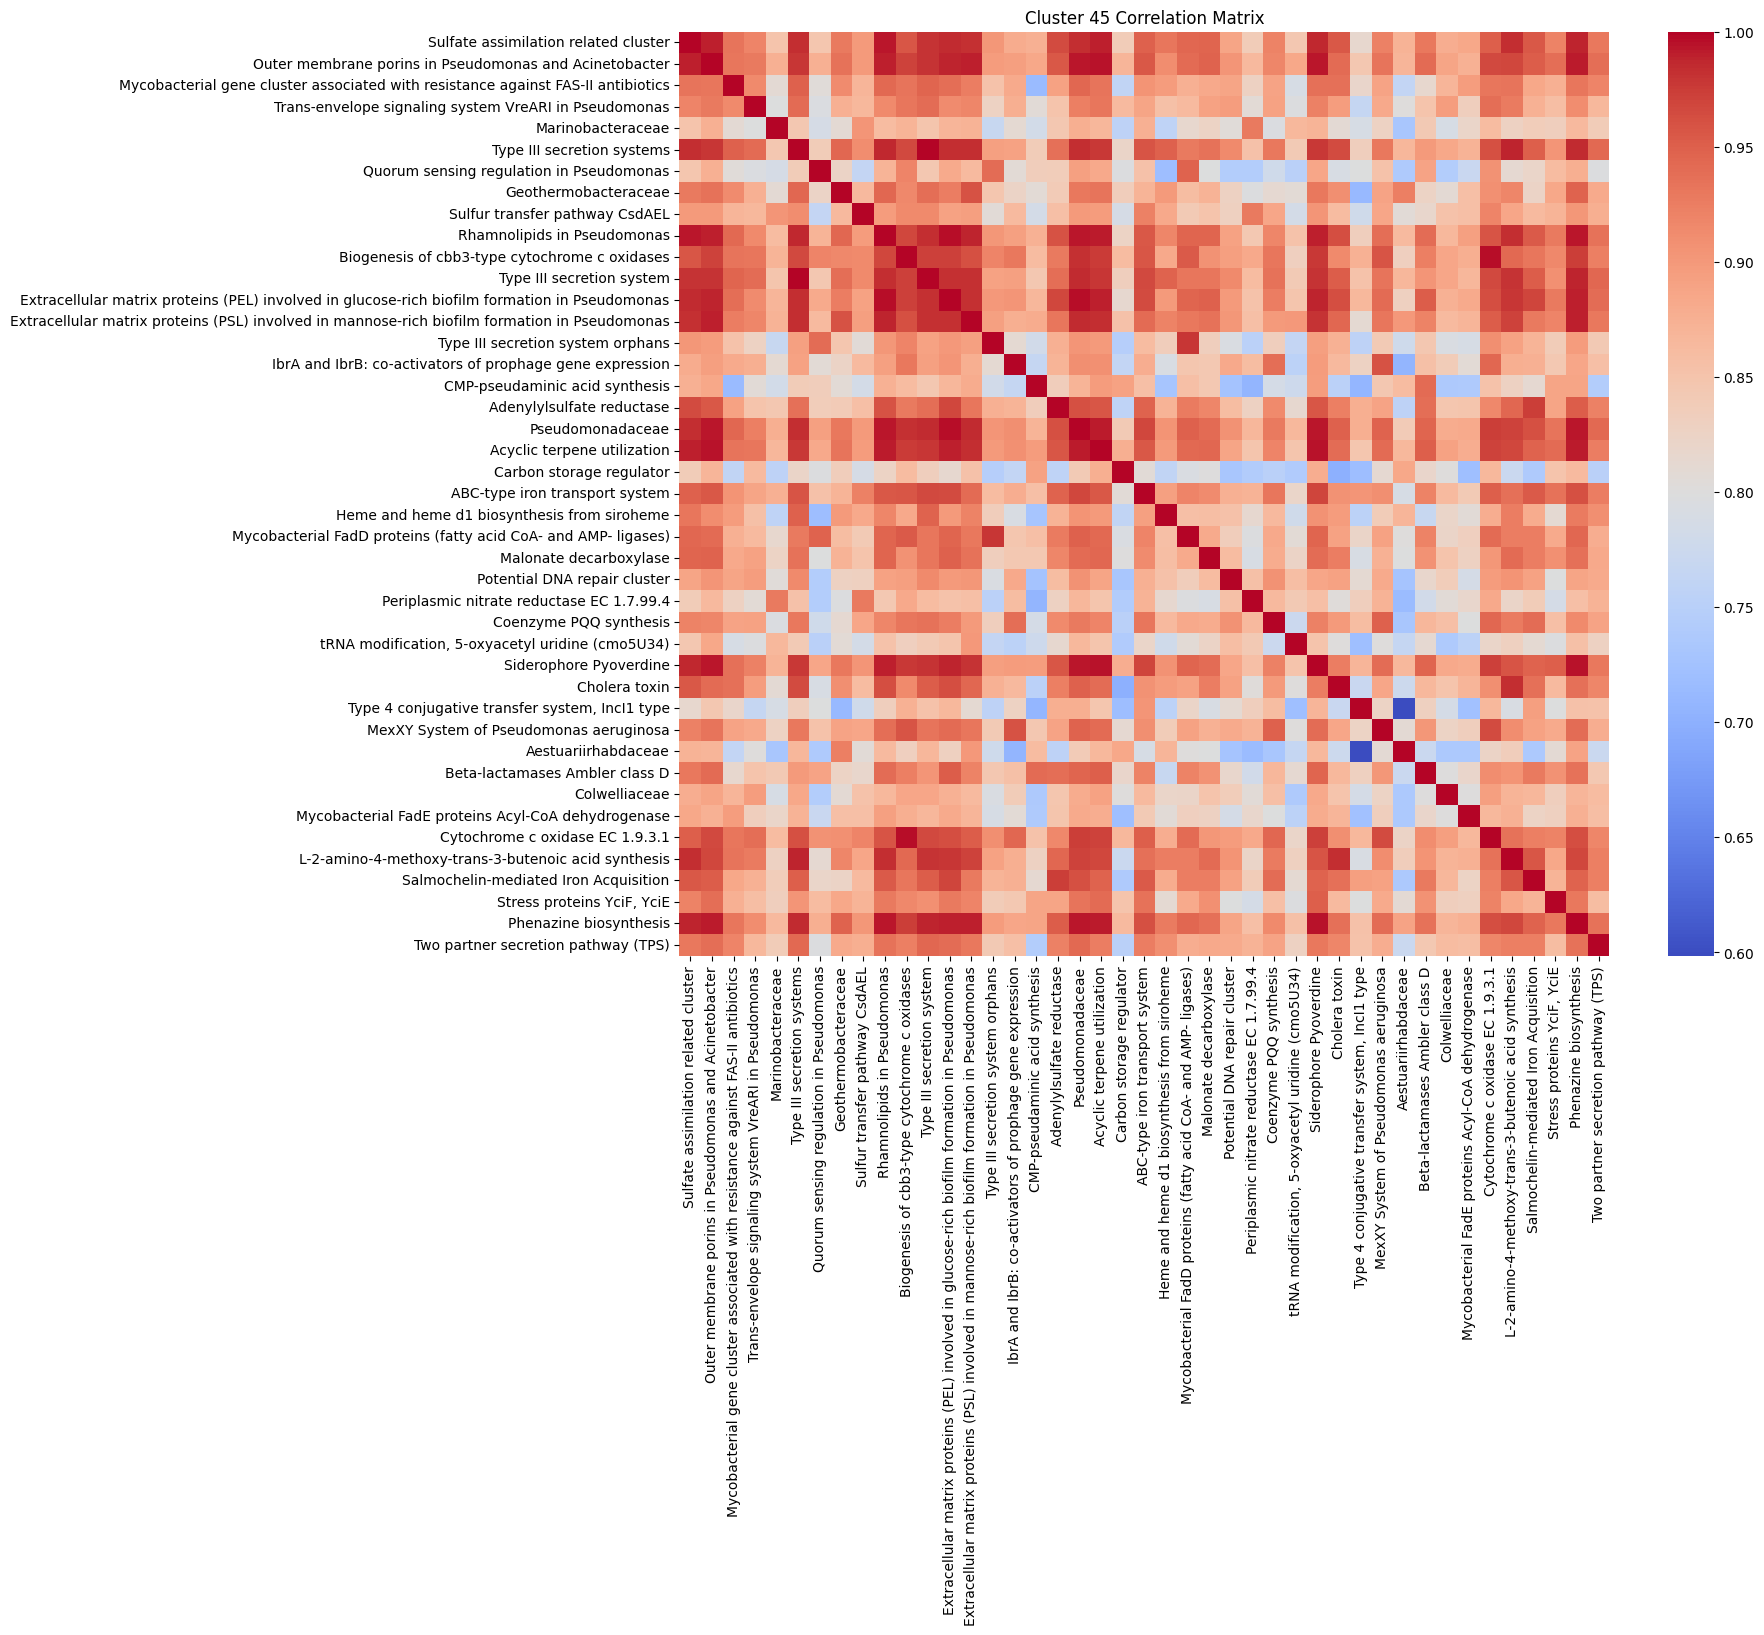

In [17]:
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
df_clust_corr = df_clust.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(df_clust_corr, annot=False, cmap='coolwarm')
plt.title(f'Cluster {interesting_cluster} Correlation Matrix')
plt.show()

### A useless aside: using a graph based approach to try and automatically get the clusters

Remember that `corr_matrix` is our correlation between the 1,512 features and the ~50 latent variables that are the outputs from the ANN.

This doesn't work so well - most of our clusters are singletons and only 5 clusters have >1 item!

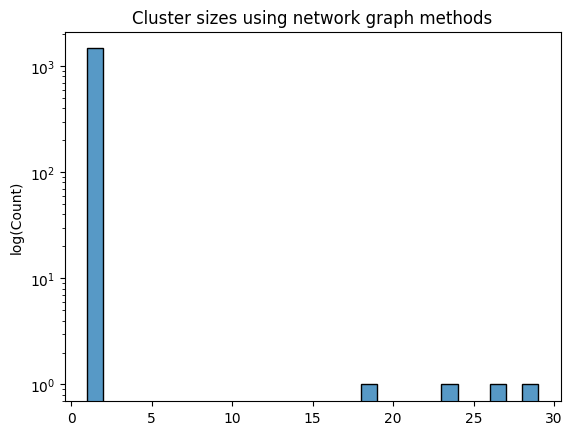

In [18]:
G = nx.Graph()

# Add nodes - each feature
for feature in corr_matrix.index:
    G.add_node(feature)

# Add edges for strong positive correlations
for i, row in enumerate(corr_matrix.index):
    for j, col in enumerate(corr_matrix.columns):
        value = corr_matrix.iloc[i, j]
        if value > 0 and i < j:  # i < j to avoid double counting
            G.add_edge(row, col, weight=value)
partition = community.best_partition(G, weight='weight')

cluster_sizes = dict(Counter(partition.values()))
g = sns.histplot(cluster_sizes, binwidth=1)
plt.title("Cluster sizes using network graph methods")
plt.ylabel("log(Count)")
plt.yscale('log')
plt.show()

## Creating a new df with principal components of the data

Here, we make a new data frame that has the PC1 for each _cluster_. This doesn't matter if the cluster has positive/negative correlations because we are looking at the PC.

We can use this matrix in our machine learning approaches like gradient boosted random forest!

In [19]:
pca = PCA(n_components=1)
pc_df = pd.DataFrame(index=df.index, columns=[f"Cluster {x+1}" for x in range(len(cluster_assignments.groupby("Cluster").size()))])
for cluster_id, group in grouped:
    df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == cluster_id, "Feature"]]
    pc_df[f"Cluster {cluster_id}"] = pca.fit_transform(df_clust).ravel()
pc_df

Cluster 1   Cluster 2    Cluster 3    Cluster 4  \
1068841_20180306_S  1333.616082   93.523795   463.067441  1274.906883   
1447437_20171212_S  1428.796197  499.861256   955.651701  1632.038575   
1128691_20171206_S -3966.477322   82.162090 -2972.660114 -6175.838860   
1128691_20171218_S -3388.833001 -103.312371 -2501.908066 -4971.199893   
1128691_20180116_S -4530.847672 -135.146481 -3183.050949 -6704.263888   
...                         ...         ...          ...          ...   
895293_20180502_S   -668.773653  -63.729206  -937.500304   501.906641   
896213_20180427_S   -982.022756 -232.708718  -260.200344 -1017.044268   
913873_20180417_S   -311.410019 -490.009139  -805.857652  -242.439529   
980574_20180403_S   -489.991192   16.460833  -694.598672    85.522836   
983493_20180123_S  -1915.645422   82.131918 -1289.520990 -3484.734563   

                      Cluster 5    Cluster 6    Cluster 7    Cluster 8  \
1068841_20180306_S   486.146886   217.269794  1418.298553   982.439990   
1447437_20171212_S  4439.900764  -697.428197  3097.421379 -3990.390414   
1128691_20171206_S -3059.570228 -1075.515990 -7018.028162 -5088.862228   
1128691_20171218_S -1917.262853 -1065.700003 -5849.988573 -4032.246898   
1128691_20180116_S -3473.114236 -1326.648403 -7713.603291 -4710.848619   
...                         ...          ...          ...          ...   
895293_20180502_S   -381.570592   534.439205  2321.034379  2695.998611   
896213_20180427_S  -1052.234707   108.042970     9.368448  1200.235524   
913873_20180417_S   -233.436770  -729.383569  1023.126805 -1105.909508   
980574_20180403_S   -110.334632   295.703873  1925.456932  -228.266905   
983493_20180123_S  -1359.078700  1140.760334 -4078.526866 -1953.264285   

                      Cluster 9     Cluster 10  ...  Cluster 141  Cluster 142  \
1068841_20180306_S  1853.665398   97583.490882  ...  -499.788393  -231.107075   
1447437_20171212_S -1920.800676  -53458.537681  ...  2942.025113   527.652745   
1128691_20171206_S -1545.660627 -195350.560469  ...   962.926598  -166.623063   
1128691_20171218_S -1179.426731 -173494.008474  ...  1083.473614  -182.457895   
1128691_20180116_S -1914.673485 -215982.908836  ...   898.449753  1788.766209   
...                         ...            ...  ...          ...          ...   
895293_20180502_S   -572.187928   90353.378530  ...  -239.175518  -645.529612   
896213_20180427_S    -65.971431  -42552.772744  ...  -416.910844  -599.375341   
913873_20180417_S   -464.674844   -1808.966170  ...  -756.000831  -130.085415   
980574_20180403_S   -519.817611   -2488.157116  ...  -291.370009   -63.208732   
983493_20180123_S   -857.318049  -50571.639131  ...   610.504502   510.988534   

                    Cluster 143  Cluster 144  Cluster 145  Cluster 146  \
1068841_20180306_S  -913.240624   263.158056  -355.030488  -951.909690   
1447437_20171212_S  9607.862498  2658.745438   897.426305  6274.578550   
1128691_20171206_S  8404.140077  -627.063918 -1095.518395 -1307.423425   
1128691_20171218_S  8004.993599   -52.541366  -947.686167  -617.862260   
1128691_20180116_S  7974.721462 -1064.576406 -1231.203370 -1717.992464   
...                         ...          ...          ...          ...   
895293_20180502_S  -1840.061011   422.598709  1882.364473 -1179.632055   
896213_20180427_S   4537.653003  -960.889635 -1022.361719  -592.242841   
913873_20180417_S   6926.226496  -673.484878 -1061.261780   752.238341   
980574_20180403_S  -2315.806032  -574.011867   192.210961  -541.197738   
983493_20180123_S   5683.685230  -797.912555   456.656412  -652.476476   

                    Cluster 147  Cluster 148  Cluster 149  Cluster 150  
1068841_20180306_S  -190.604364  -406.638458    30.105645  -328.121079  
1447437_20171212_S   429.643238  1126.913807   170.647659   666.616343  
1128691_20171206_S  -302.680976 -1380.503701   -84.634852 -1326.000661  
1128691_20171218_S  -123.573548 -1166.307959  -199.406936  -974.896388  
1128691_20180116_S   -99.8729

### Plot a PCA

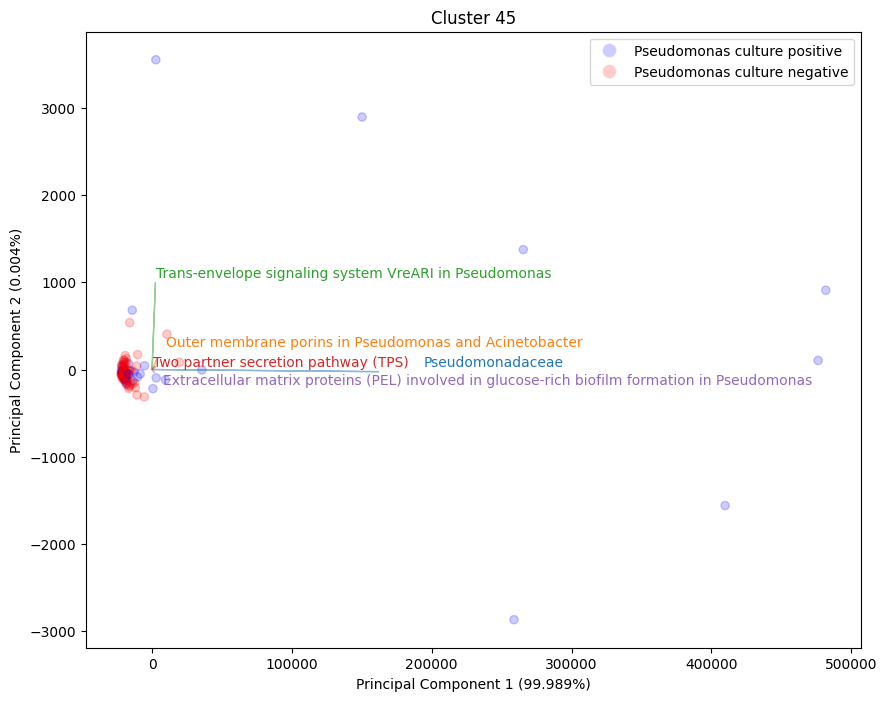

In [20]:
pca = PCA(n_components=2)

intcol = 'Pseudomonas Culture'
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
merged_df_clust = df_clust.join(metadata[[intcol]])

pca_result = pca.fit_transform(df_clust)
pca_df = pd.DataFrame(data=pca_result, index=df.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=df_clust.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
top_loadings_df.head()

explained_variance = pca.explained_variance_ratio_ * 100
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]

colours = np.where(merged_df_clust['Pseudomonas Culture'] == 1, 'blue', 'red')

# Plot the PCA results
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours)
plt.title(f"Cluster {interesting_cluster}")
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 5
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)
found_pseudomonas = False
for i in range(maxloadings):
    c = next(colour_cycle)
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color=c, alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color=c))

adjust_text(texts)


# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', alpha=0.2, markersize=10)


plt.legend(handles=[blue_patch, red_patch])


# Show the plot
plt.show()

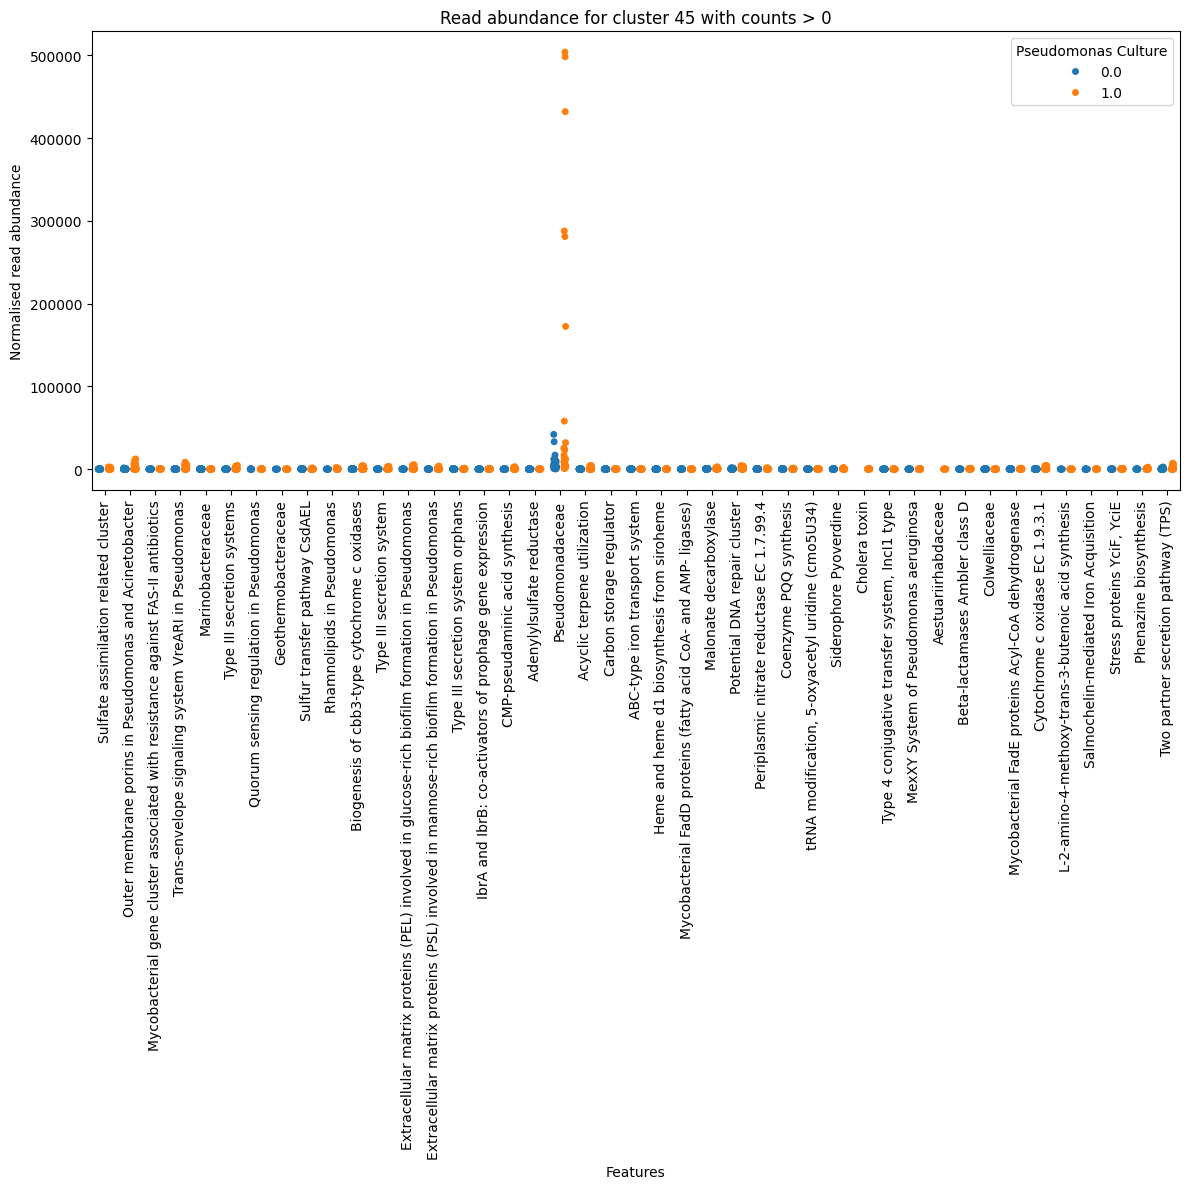

In [22]:
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
merged_df_clust = df_clust.join(metadata[[intcol]])
df_clust_m = merged_df_clust.melt(id_vars=intcol, var_name='Features', value_name='Normalised read abundance')
df_clust_m = df_clust_m[df_clust_m['Normalised read abundance'] > 0]
plt.figure(figsize=(12, 12))
sns.stripplot(data=df_clust_m, x='Features', y='Normalised read abundance', hue=intcol, dodge=True, jitter=True)
plt.xticks(rotation=90)
# plt.ylim(0, 10000)
plt.title(f"Read abundance for cluster {interesting_cluster} with counts > 0")
plt.tight_layout()
plt.show()

# GBRF

This code is directly from the GBRF page, but we are using pc_df instead of df, and we're going to predict `Pseudomonas culture`

When we run this multiple times, we get the same answer! Now we only need to run the GBRF once per metadata column

Running the regressor on Pseudomonas Culture has an average mse of 0.13886244099277728


Cluster 45: 0.0340 (3 times)
Cluster 46: 0.0260 (3 times)
Cluster 87: 0.0244 (3 times)
Cluster 114: 0.0138 (2 times)
Cluster 50: 0.0117 (2 times)
Cluster 85: 0.0110 (3 times)
Cluster 40: 0.0108 (2 times)
Cluster 123: 0.0101 (2 times)
Cluster 27: 0.0091 (2 times)
Cluster 41: 0.0088 (2 times)


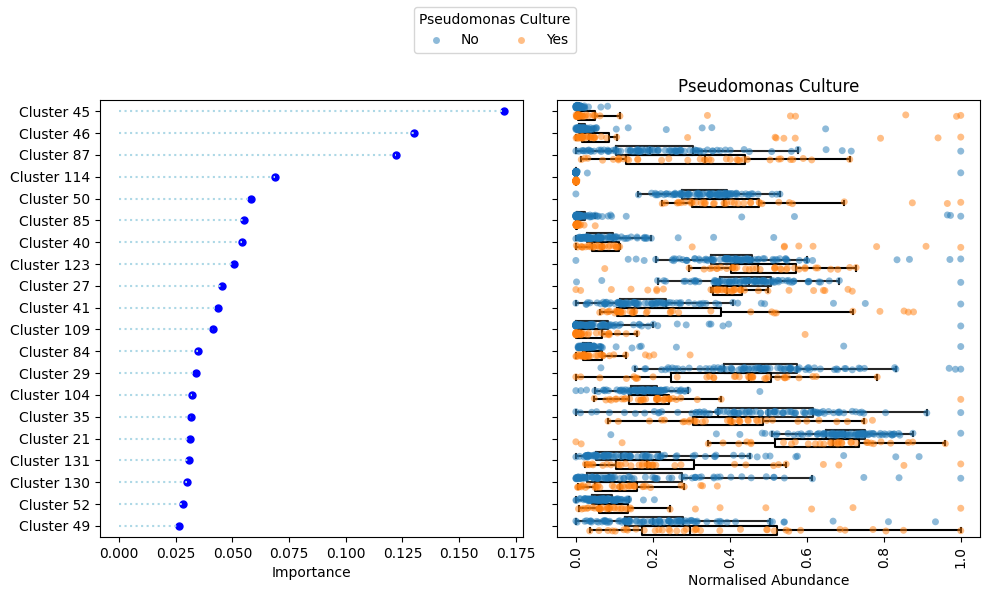

In [23]:
intcol = 'Pseudomonas Culture'

replace_index = re.compile(r'^\d+\s+')
intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

# do we need to encode this column
custom_labels = {0: 'No', 1: 'Yes'}
categorical_data = False
if pd.api.types.is_numeric_dtype(metadata[intcol]):
    # this is an numeric column, so we can just continue
    pass
elif isinstance(metadata[intcol].dtype, pd.CategoricalDtype) and pd.api.types.is_numeric_dtype(metadata[intcol].cat.categories.dtype):
    # this is a categorical column with numeric categories so we can also continue
    categorical_data = True
elif isinstance(metadata[intcol].dtype, pd.CategoricalDtype):
    # this is a categorical column with string categories so we need to encode it
    enc = OrdinalEncoder()
    metadata_encoder = enc.fit(metadata[[intcol]])
    categories = metadata_encoder.categories_[0]
    custom_labels = {code: cat for code, cat in enumerate(categories)}
    merged_df[intcol] = metadata_encoder.transform(metadata[[intcol]])
    categorical_data = True
else:
    # not sure what this is, so we skip it for now
    print(f"Error: {intcol} is not a numeric or categorical column, but carrying on", file=sys.stderr)
    

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

top_features = {}
top_feature_counts = {}
niterations = 3
msetot = 0
n=20
for i in range(niterations):
    if categorical_data:
      mse, feature_importances_sorted = cf_analysis_lib.gb_classifier(X, y)
      met = 'classifier'
    else:
      mse, feature_importances_sorted = cf_analysis_lib.gb_regressor(X, y)
      met = 'regressor'
    
    msetot += mse
    
    for f in feature_importances_sorted.index[:n]:
        top_features[f] = top_features.get(f, 0) + feature_importances_sorted.loc[f, 'importance']
        top_feature_counts[f] = top_feature_counts.get(f, 0) + 1

print(f"Running the {met} on {intcol_title} has an average mse of {msetot/niterations}", file=sys.stderr)

cf_analysis_lib.plot_top_features(merged_df, top_features, top_feature_counts, intcol, intcol_title, custom_labels)

# Run the GBRF for every metadata sample

This code is taken from the gradient_boosting.py script with some minor changes, but runs the GBRF once per sample.

Working on Sample date
Error: Sample date is not a numeric or categorical column. Skipped
Working on IP vs OP
Working on Hospital
Working on Room
Error: Room is not a numeric or categorical column. Skipped
Working on Age
Couldn't use float for labels 8.0.
Working on Age groups
Couldn't use float for labels 2.0.
Working on Paediatric vs Adult
Working on Gender
Working on H2_Uncorrected
Couldn't use float for labels 20.0.
Working on CH4_Uncorrected
Couldn't use float for labels 4.0.
Working on CO2
Couldn't use float for labels 2.4.
Working on H2_Corrected
Couldn't use float for labels 25.0.
Working on CH4_Corrected
Couldn't use float for labels 6.0.
Working on CH4/H2 ratio_corrected
Couldn't use float for labels 1.5.
Working on Corr.
Couldn't use float for labels 1.2.
Working on Culture Result (Matched with sequenced sample)
Error: Culture Result (Matched with sequenced sample) is not a numeric or categorical column. Skipped
Working on NTM
Working on Pseudomonas Culture
Working on Cuture

KeyboardInterrupt: 

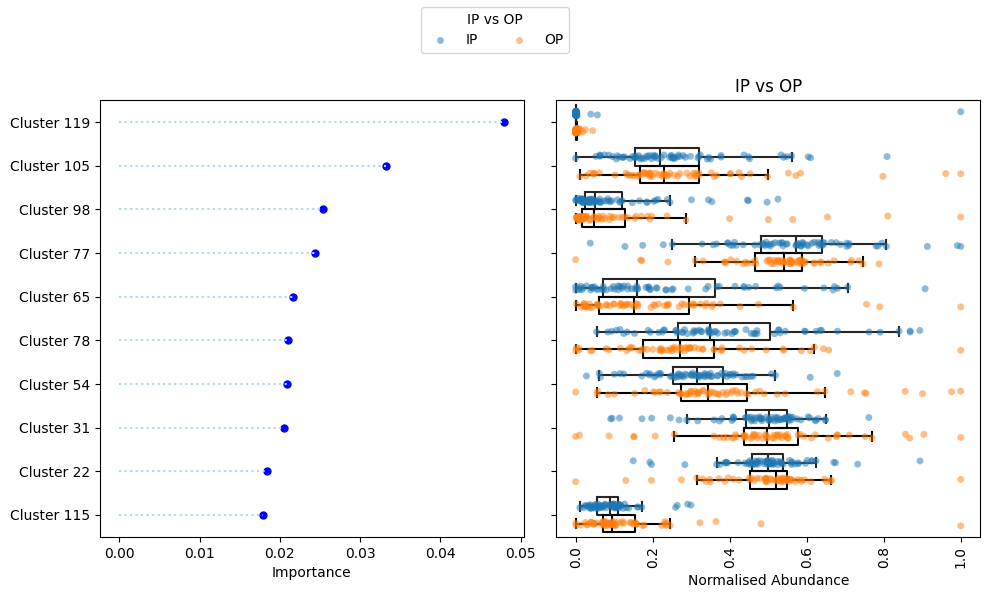

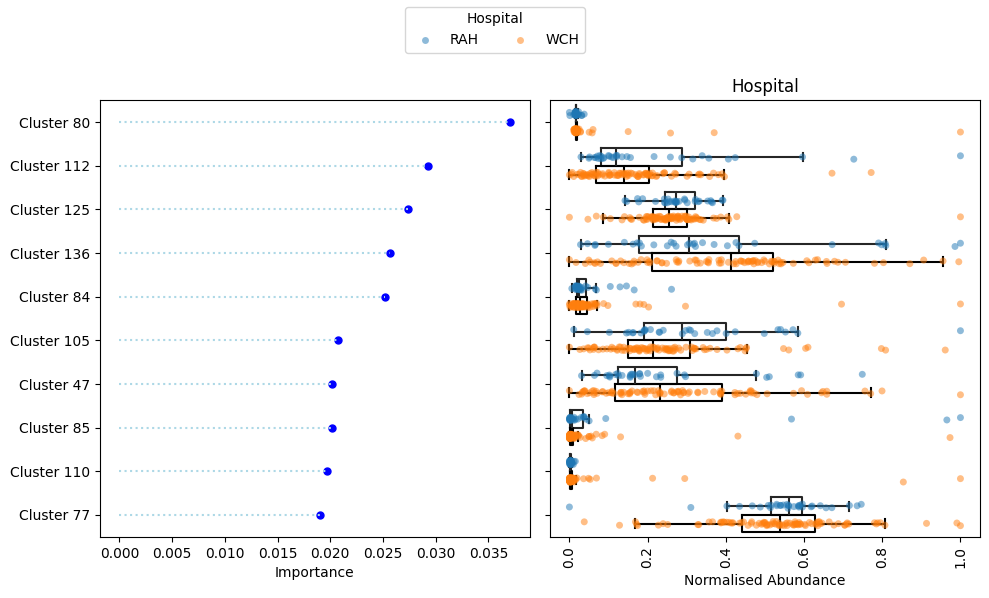

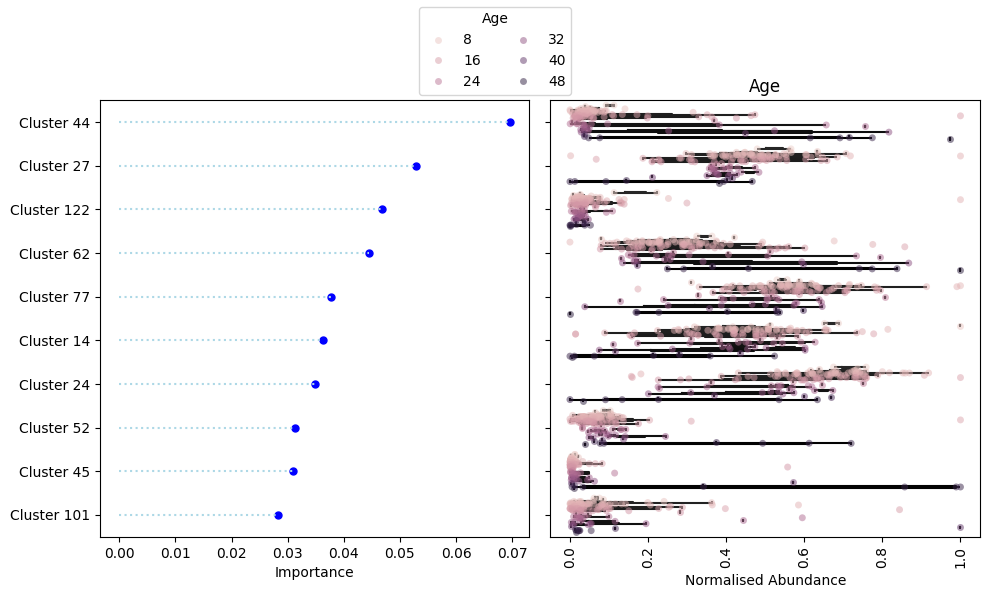

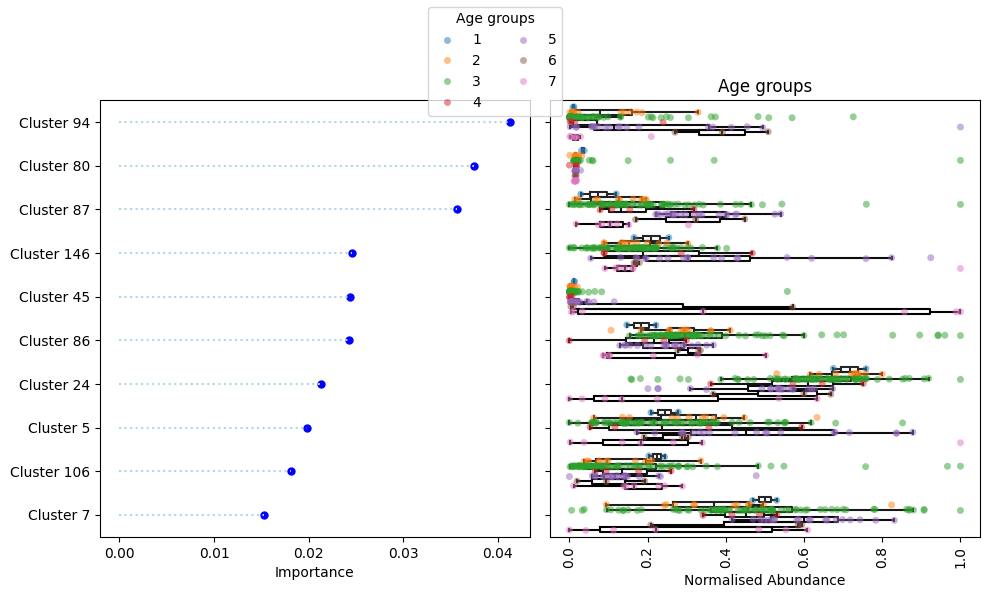

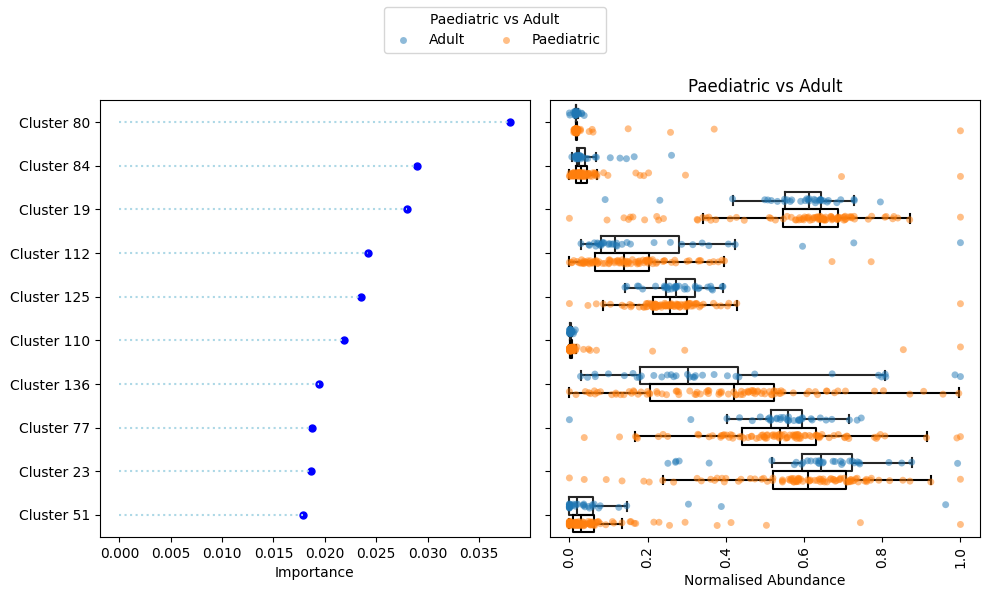

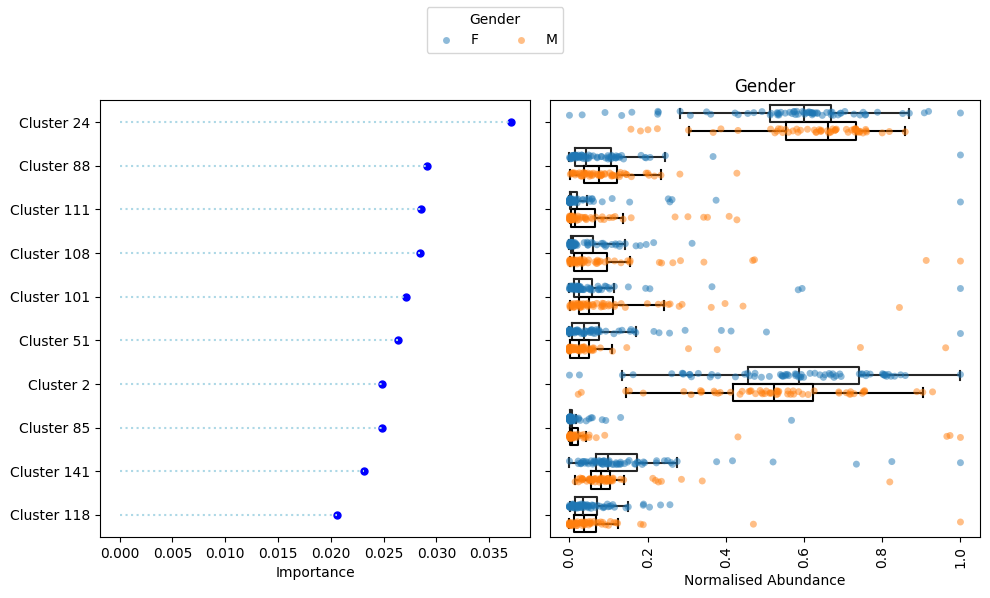

Error in callback <function flush_figures at 0x1553ed69da80> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [26]:
replace_index = re.compile(r'^\d+\s+')
replace_nonword = re.compile(r'\W+')

resultsfile = open(os.path.join(outdir, 'gbrf_results.txt'), 'w')
print(f"Predictor\tFeature\tImportance", file=resultsfile)

skip_columns = {'minion', 'MGI', 'pwCF_ID', 'Sample_Type'}

for intcol in metadata.columns:
    if intcol in skip_columns:
        continue
    print(f"Working on {intcol}", file=sys.stderr)

    # set up our titles and the filename
    intcol_title = replace_index.sub('', intcol)
    intcol_filename = intcol.replace(" ", "_")
    intcol_filename = replace_nonword.sub('', intcol_filename)

    merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

    # do we need to encode this column
    custom_labels = {0: 'No', 1: 'Yes'}
    categorical_data = False
    if pd.api.types.is_numeric_dtype(metadata[intcol]):
        # this is an numeric column, so we can just continue
        categorical_data = False
    elif isinstance(metadata[intcol].dtype, pd.CategoricalDtype) and pd.api.types.is_numeric_dtype(metadata[intcol].cat.categories.dtype):
        # this is a categorical column with numeric categories so we can also continue
        categorical_data = True
    elif isinstance(metadata[intcol].dtype, pd.CategoricalDtype):
        # this is a categorical column with string categories so we need to encode it
        enc = OrdinalEncoder()
        metadata_encoder = enc.fit(metadata[[intcol]])
        categories = metadata_encoder.categories_[0]
        custom_labels = {code: cat for code, cat in enumerate(categories)}
        merged_df[intcol] = metadata_encoder.transform(metadata[[intcol]])
        categorical_data = True
    else:
        # not sure what this is, so we skip it for now
        print(f"Error: {intcol} is not a numeric or categorical column. Skipped", file=sys.stderr)
        continue

    X = merged_df.drop(intcol, axis=1)
    y = merged_df[intcol]


    met = None

    if categorical_data or metadata[intcol].dtype == 'object':
        mse, feature_importances_sorted = cf_analysis_lib.gb_classifier(X, y)
        met = 'classifier'
    else:
        mse, feature_importances_sorted = cf_analysis_lib.gb_regressor(X, y)
        met = 'regressor'

    print(f"Mean squared error for {intcol} using {met} is {mse}", file=resultsfile)
    
    print(f"Features appearing at least once", file=resultsfile)
    for x in feature_importances_sorted:
        print(f"{intcol}\t{x}\t{feature_importances_sorted[x]}", file=resultsfile)
        
    y_features = 10

    topN = list(feature_importances_sorted[:y_features].index) + [intcol]
    fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=2, sharey='row', sharex='col')
    cf_analysis_lib.plot_feature_importance(axes[0], feature_importances_sorted[:y_features][::-1], "")
    cf_analysis_lib.plot_feature_abundance(axes[1], merged_df[topN][::-1], intcol, intcol_title)


    handles, labels = axes[1].get_legend_handles_labels()  # Get one set of handles and labels
    updated_labels = labels
    try:
        updated_labels = [custom_labels[float(label)] for label in labels]
    except Exception as e:
        print(f"Couldn't use float for labels {e}.", file=sys.stderr)

    for ax in axes.flat:
        if ax.get_legend() is not None:  # Check if legend exists
            ax.get_legend().remove()

    plt.xticks(rotation=90)
    fig.legend(handles, updated_labels, loc='upper center', ncol=2, title=intcol_title)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.savefig(os.path.join(outdir, f"{intcol_filename}.png"))
    plt.close()

resultsfile.close()